In [1]:
import spacy
from co_occurance.generate import Comet
nlp = spacy.load('en_core_web_md')


/home/jeongeun/.pyenv/versions/det/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pkill thor_*
import ai2thor
from ai2thor.controller import Controller,BFSController
from ai2thor.platform import CloudRendering
from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection
from ithor_tools.map import single_scenemap
from ithor_tools.astar import astar
import random
from co_occurance.move import co_occurance_based_schedular
import math
from IPython.display import display
from moviepy.editor import ImageSequenceClip,VideoFileClip

"AI2-THOR Version: " + ai2thor.__version__

'AI2-THOR Version: 4.2.0'

In [3]:
print("model loading ...")
DIR = "./co_occurance/comet-atomic_2020_BART"
comet = Comet(DIR)
comet.model.zero_grad()
print("model loaded")


model loading ...
model loaded


In [4]:
gridSize=0.01

controller = Controller(
    platform = CloudRendering,
    agentMode="locobot",
    visibilityDistance=5.0,
    scene = "FloorPlan_Train11_4",
    gridSize=gridSize,
    movementGaussianSigma=0,
    rotateStepDegrees=90,
    rotateGaussianSigma=0,
    renderDepthImage=False,
    renderInstanceSegmentation=False,
    width=300,
    height=300,
    fieldOfView=60
)
landmark_names = ['Bed', 'DiningTable', 'StoveBurner', 'Toilet', 'Sink', 'Desk',
                        'CounterTop','Television','Sofa','SideTable','CoffeeTable','ShelvingUnit','ArmChair']
Word_Dict = {
    'Bed': 'bed', 'DiningTable': 'dining table', 'StoveBurner': 'stove', 'Toilet': 'toilet', 'Sink': 'sink',
    'Desk': 'Desk', 'CounterTop':'kitchen table', 'Sofa':'sofa', 'Television':'television', 'SideTable':'table', 
        'CoffeeTable':'round table','ShelvingUnit':'shelving','ArmChair':'arm chair'}

In [5]:
controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderInstanceSegmentation=False,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)
scene_bounds = controller.last_event.metadata['sceneBounds']['center']
controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=5.0, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize= 5.0, fieldOfView=100,
    skyboxColor="white"
)
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']

controller.step(
    action="Teleport",
    position = rstate[100]
)

pos = controller.last_event.metadata['agent']['position']
pos = [pos['x'],pos['z']]
objects = controller.last_event.metadata['objects']

In [6]:
df = show_objects_table(objects)
df

Object Metadata. Not showing objectOrientedBoundingBox, axisAlignedBoundingBox, and receptacleObjectIds for clarity.


,objectType,objectId,name,position[x],position[y],position[z],rotation[x],rotation[y],rotation[z],distance,...,openness,pickupable,isPickedUp,moveable,mass,salientMaterials,assetId,parentReceptacles,controlledObjects,isMoving
0,Box,Box|+01.32|+00.24|-02.71,Box_12,1.3250,0.2405,-2.7123,-0.0024,0.0001,0.0000,2.1954,...,1.0,True,False,False,0.30,[Paper],Box_12,[Floor|+00.00|+00.00|+00.00],None,False
1,Statue,Statue|+09.25|+00.74|-02.78,Waving_Statue_2,9.2529,0.7415,-2.7845,0.0797,218.3742,0.0788,6.4195,...,0.0,True,False,False,1.00,[Stone],Waving_Statue_2,[DiningTable|+09.01|+00.00|-03.00],None,False
2,AlarmClock,AlarmClock|+01.28|+00.48|-04.63,Alarm_Clock_24,1.2835,0.4783,-4.6341,0.0081,60.0002,-0.0022,3.6501,...,0.0,True,False,False,0.80,"[Metal, Plastic, Glass]",Alarm_Clock_24,"[SideTable|+01.23|+00.00|-04.66, Floor|+00.00|...",None,False
3,Bottle,Bottle|+08.37|+00.74|-03.32,Bottle_1,8.3749,0.7416,-3.3181,359.8951,0.1398,0.0140,5.7180,...,0.0,True,False,False,0.20,[Glass],Bottle_1,[DiningTable|+09.01|+00.00|-03.00],None,False
4,Laptop,Laptop|+01.71|+00.35|-01.61,Laptop_24,1.7094,0.3512,-1.6117,347.3787,120.3532,359.9427,1.3963,...,1.0,True,False,False,2.30,"[Metal, Plastic, Glass]",Laptop_24,"[ArmChair|+01.62|+00.00|-01.54, Floor|+00.00|+...",[],False
5,FloorLamp,FloorLamp|+04.23|00.00|-03.09,Floor_Lamp_21,4.2270,-0.0010,-3.0870,0.0054,0.0013,0.0140,2.2615,...,0.0,False,False,True,3.93,[Metal],Floor_Lamp_21,[Floor|+00.00|+00.00|+00.00],[],False
6,BasketBall,BasketBall|+01.13|+00.12|-04.34,Basketball_1,1.1323,0.1200,-4.3409,-0.0000,-0.0000,43.4934,3.5351,...,0.0,True,False,False,0.60,[Rubber],Basketball_1,[Floor|+00.00|+00.00|+00.00],None,False
7,BaseballBat,BaseballBat|+06.13|+00.68|-01.11,BaseballBat_2,6.1279,0.6817,-1.1069,349.2352,180.1767,179.9622,3.1720,...,0.0,True,False,False,0.90,[Wood],BaseballBat_2,[Floor|+00.00|+00.00|+00.00],None,False
8,RemoteControl,RemoteControl|+03.13|+00.40|-02.91,Remote_3,3.0079,0.3972,-2.9128,359.8084,148.6981,0.7457,1.5664,...,0.0,True,False,False,0.15,"[Metal, Plastic]",Remote_3,"[CoffeeTable|+02.43|+00.00|-02.78, Floor|+00.0...",None,True
9,SaltShaker,SaltShaker|+03.14|+00.40|-02.57,Salt_Shaker_2,3.0153,0.3950,-2.5818,0.2771,2.3384,0.3841,1.2585,...,0.0,True,False,False,0.60,"[Metal, Glass]",Salt_Shaker_2,"[CoffeeTable|+02.43|+00.00|-02.78, Floor|+00.0...",None,True


In [7]:
landmarks = []
for obj in objects:
    if obj['objectType'] in landmark_names:
        cp = obj["position"]
        flag = True
        for l in landmarks:
            if abs(l['cp']['x']-cp['x'])+ abs(l['cp']['z']-cp['z']) < 0.7: #and l['name']==obj['objectType']
                flag = False
                break
        if flag:
            landmarks.append(dict(cp = cp, name=obj['objectType']))
        
visible_landmark_name = []
for l in landmarks:
    if l['name'] not in visible_landmark_name:
        visible_landmark_name.append(l['name'])

In [62]:
scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)

# query_object = random.choice(objects)
query_object = objects[8]
query_object_name = query_object['objectType']
landmark_cat = [Word_Dict[l] for l in visible_landmark_name]
print(query_object_name)


RemoteControl


0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789
0
(418, 713, 4)


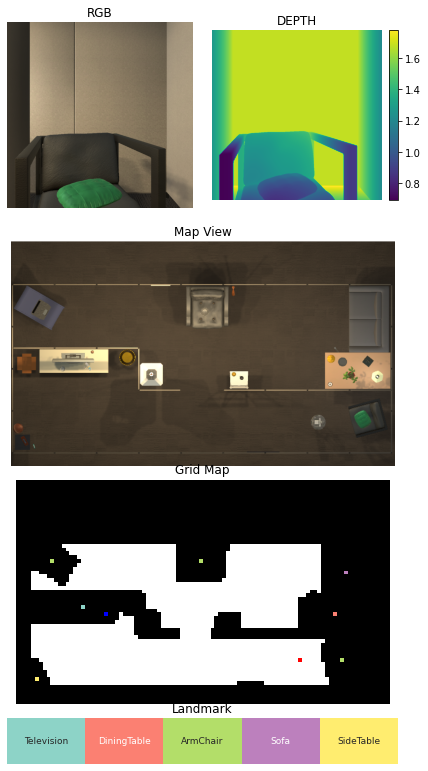

In [63]:
## Notice stepsize should be smaller than gridsize
stepsize = gridSize
sm = single_scenemap(scene_bounds,rstate,stepsize = 0.1,landmark_names=visible_landmark_name,landmarks=landmarks)
landmark_config = dict(name=visible_landmark_name,color = sm.landmark_colors)
imshow_grid = sm.plot(controller.last_event.metadata['agent']['position'],query_object['position'])
plot_frames(controller.last_event,imshow_grid,landmark_config)


In [64]:
queries = []

new_query_object_name = ''

for i, letter in enumerate(query_object_name):
    if i and letter.isupper():
        new_query_object_name += ' '
    new_query_object_name += letter

head = "A {}".format(new_query_object_name).lower()
rel = "AtLocation"
query = "{} {} [GEN]".format(head, rel)
queries.append(query)
print(queries)
results = comet.generate(queries, decode_method="beam", num_generate=20)
print(results)

['a remote control AtLocation [GEN]']
[[' television', ' television set', ' tv set', ' tv room', ' tv', ' remote control', ' desk drawer', ' cable box', ' tv cabinet', ' tv remote', ' armchair', ' tv show', ' television room', ' TV set', ' television cabinet', ' tv screen', ' a car', ' movie theater', ' tv stand', ' TV room']]


In [65]:
# results = [['{}'.format(query_object_name).lower()]]
res = []
for l in landmark_cat:
    sims = []
    for r in results[0]:
        doc1 = nlp(r)
        doc2 = nlp(l)

        sims.append(doc1.similarity(doc2))
    res.append(round(max(sims),3))
print(head)
print(visible_landmark_name)
print(res)

a remote control
['Television', 'DiningTable', 'ArmChair', 'Sofa', 'SideTable']
[1.0, 0.587, 0.279, 1.0, 0.67]


In [66]:
thres = 0.3
schedular = co_occurance_based_schedular(landmarks,visible_landmark_name)
schedular.get_graph(sm,controller,res,thres)
print(schedular.node, schedular.edge)

[-1, 1.0, 0.587, 1.0, 0.67] [[0.         5.71401813 4.82072057 5.59717446 6.01916985]
 [5.71401813 0.         5.41480892 6.19126281 0.92973109]
 [4.82072057 5.41480892 0.         1.25299661 5.88799711]
 [5.59717446 6.19126281 1.25299661 0.         6.664451  ]
 [6.01916985 0.92973109 5.88799711 6.664451   0.        ]]


In [67]:
path = schedular.optimize()
path

[0, 1, 3, 2, 4]


[({'x': 8.100000381469727, 'y': 0.9009997844696045, 'z': -4.199999809265137},
  0),
 [{'x': 2.4000000000000004, 'y': 0.91, 'z': -3.8000000000000007}, 0, 1.0],
 [{'x': 8.1, 'y': 0.91, 'z': -1.9000000000000004}, 90, 1.0],
 [{'x': 7.500000000000001, 'y': 0.91, 'z': -3.0000000000000004}, 90, 0.587],
 [{'x': 2.1, 'y': 0.91, 'z': -4.700000000000001}, 270, 0.67]]

In [68]:
schedular.node_info

[({'x': 8.100000381469727, 'y': 0.9009997844696045, 'z': -4.199999809265137},
  0),
 [{'x': 2.4000000000000004, 'y': 0.91, 'z': -3.8000000000000007}, 0, 1.0],
 [{'x': 7.500000000000001, 'y': 0.91, 'z': -3.0000000000000004}, 90, 0.587],
 [{'x': 8.1, 'y': 0.91, 'z': -1.9000000000000004}, 90, 1.0],
 [{'x': 2.1, 'y': 0.91, 'z': -4.700000000000001}, 270, 0.67]]

980 590


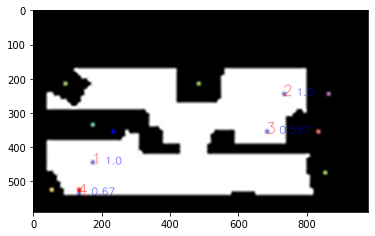

In [73]:
import copy
temp = copy.deepcopy(sm.grid_map)
temp = np.ascontiguousarray(temp*255, dtype=np.uint8).copy()
pos = controller.last_event.metadata['agent']['position']
pos = sm.xyz2grid(pos)
temp[pos[0],pos[1]] = [255,0,0]
pos = query_object['position']
pos = sm.xyz2grid(pos)
temp[pos[0],pos[1]] = [0,0,255]
for points in path[1:]:
    pos = sm.xyz2grid(points[0])
    temp[pos[0],pos[1]] = [100,100,200]
temp = cv2.resize(temp, dsize = (-1,-1),fx = 10,fy=10,interpolation = cv2.INTER_CUBIC)
h,w = temp.shape[0], temp.shape[1]
print(h,w)
temp = cv2.rotate(temp, cv2.ROTATE_90_COUNTERCLOCKWISE)
for e,points in enumerate(path[1:]):
    pos = sm.xyz2grid(points[0])
    temp = cv2.putText(temp, str(e+1), (10*pos[0], w-10*pos[1]),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255, 0, 0),1,cv2.LINE_AA)
    temp = cv2.putText(temp, str(points[2]), (10*pos[0]+40, w-10*pos[1]),cv2.FONT_HERSHEY_SIMPLEX,1,(0, 0, 255),1,cv2.LINE_AA)
plt.imshow(temp)
plt.show()

True
(418, 713, 4)


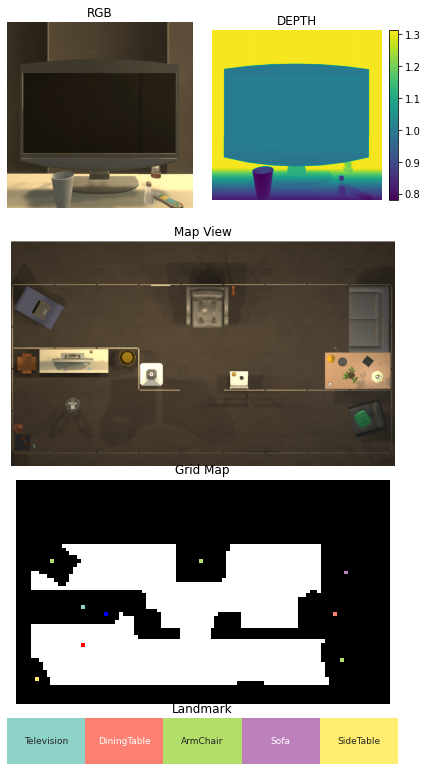

True
(418, 713, 4)


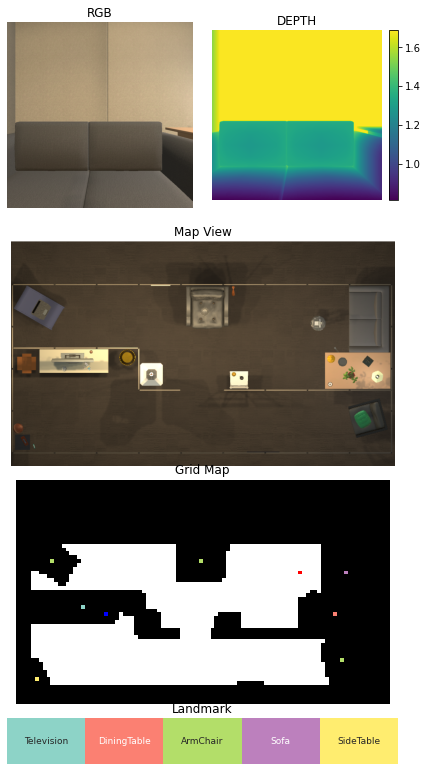

True
(418, 713, 4)


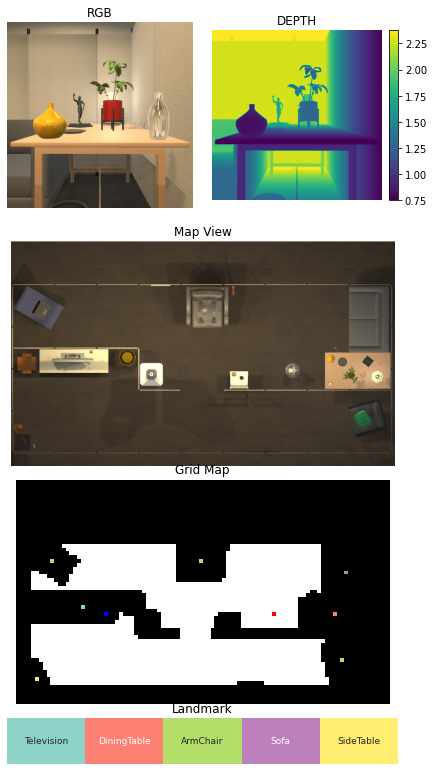

True
(418, 713, 4)


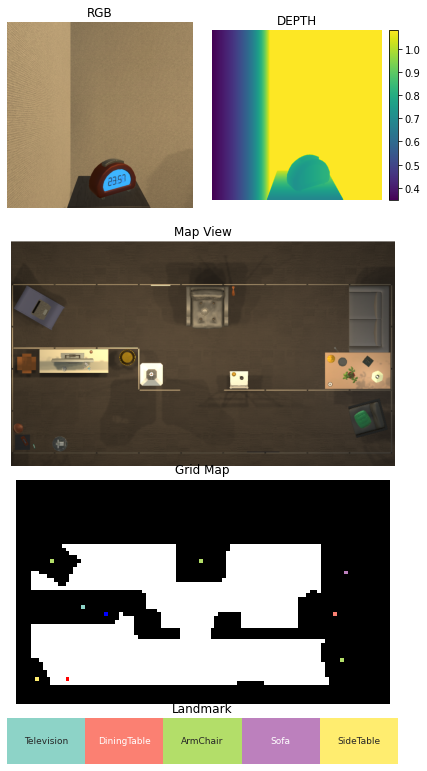

In [70]:
for p in path[1:]:
    controller.step(action="Teleport",
                    position = p[0], rotation = dict(x=0,y=p[1],z=0))
    pos = controller.last_event.metadata['agent']['position']
    print(controller.last_event.metadata['lastActionSuccess'])
    imshow_grid = sm.plot(pos,query_object['position'])
    plot_frames(controller.last_event,imshow_grid,landmark_config)